In [1]:
import numpy as np
# from cart_pole_env import CartPoleSwingUpEnv
# from cart_pole_model import CartPoleModel
from custom_cartpoleswingup import CartPoleSwingUpEnv
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
class IndirectController(object):

    def __init__(self, model, task, T=20):
        self.T = T
        self.nu = model.action_space.shape[0]
        self.nx = model.observation_space.shape[0]
        self.u = [np.random.normal(0., 0.1, size=(self.nu,)) for t in range(T-1)]
        
        self.model = model
        self.task  = task
        
    def __call__(self, state):
        
        self.u[:-1] = self.u[1:]
        self.u[-1]  = np.zeros(self.nu)
        
        self.model.set_state(state)
        A = []
        B = []
        ldx = []
        ldu = []
        for t in range(self.T-1):
            ldx_t = self.task.ldx(self.model.state)
            ldu_t = self.task.ldu(self.u[t])
            
            self.model.step(self.u[t])
            A_t = self.model.A
            B_t = self.model.B

            A.append(A_t)
            B.append(B_t)
            ldx.append(ldx_t)
            ldu.append(ldu_t)
        
        _rho = []
        rho = np.zeros(self.nx)
        for t in reversed(range(self.T-1)):
            rho = np.dot(A[t].T, rho) + ldx[t]
            self.u[t] = -np.dot(B[t].T, rho) + self.u[t]

        return self.u[0].copy()
    

In [3]:
env = CartPoleSwingUpEnv()
task = env.task


In [4]:
model = CartPoleSwingUpEnv()
controller = IndirectController(model, task, T=50)



In [103]:
log = {
    'states' : [],
    'next_states' : [],
    'actions' : []
}

In [104]:
state = env.reset()

for _ in range(500):
    action = controller(state)
#     action = np.random.normal(0.,4.0, size=(1,))
    next_state = env.step(action)
    env.render()
    log['states'].append(state.copy())
    log['next_states'].append(next_state.copy())
    log['actions'].append(action.copy())
    
    state = next_state

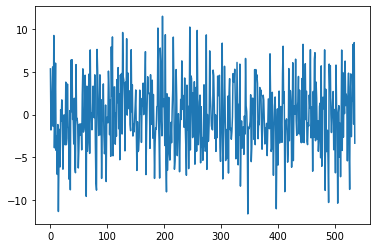

In [7]:
plt.plot(actions)
# plt.ylim(-1,1)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients


In [33]:
def compute_jacobian(inputs, output):
	"""
	:param inputs: Batch X Size (e.g. Depth X Width X Height)
	:param output: Batch X Classes
	:return: jacobian: Batch X Classes X Size
	"""
	assert inputs.requires_grad

	num_classes = output.size()[1]

	jacobian = torch.zeros(num_classes, *inputs.size())
	grad_output = torch.zeros(*output.size())
	if inputs.is_cuda:
		grad_output = grad_output.cuda()
		jacobian = jacobian.cuda()

	for i in range(num_classes):
		zero_gradients(inputs)
		grad_output.zero_()
		grad_output[:, i] = 1
		output.backward(grad_output, retain_graph=True)
		jacobian[i] = inputs.grad.data

	return torch.transpose(jacobian, dim0=0, dim1=1)

# def init_weights(m):
#     if type(m) == nn.Linear:
#         m.weight.data.uniform_(-.1,.1)
#         m.bias.data.uniform_(-.1,.1)


class Model(nn.Module):
    
    def __init__(self, nx, nu, H=128):
        super(Model, self).__init__()
#         self.linear1 = torch.nn.Linear(nx + nu, H)
#         self.linear2 = torch.nn.Linear(H, nx)
        self.nx = nx
        self.nu = nu
        
#         self.apply(init_weights)
        
        self.g = nn.Sequential(
            nn.Linear(nx+nu, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, nx)
        )
#         self.h = nn.Sequential(
#             nn.Linear(nx, H),
#             nn.ReLU(),
#             nn.Linear(H, H),
#             nn.ReLU(),
#             nn.Linear(H, nx*nu)
#         )
    
    @property
    def A(self):
        return self._A.clone()
    @property
    def B(self):
        return self._B.clone()

    def forward(self, x, u, T=1, get_jacobian=False):
        if get_jacobian:
            x = Variable(x, requires_grad=True)
            u = Variable(u, requires_grad=True)
        inputs = torch.cat([x, u], axis=1)
        g = self.g(inputs)
#         hu = self.h(x).view(-1, self.nx, self.nu).bmm(u.view(-1,self.nu,1)).squeeze(-1)
        out = x + g
        if get_jacobian:
            fdx = compute_jacobian(x, out)
            fdu = compute_jacobian(u, out)
            self._A = fdx.data
            self._B = fdu.data
        return out

In [22]:
model(states[:50,:], actions[:50,:], get_jacobian=True)

tensor([[ 3.0354e+00,  3.2519e-01, -1.0835e-01, -2.4261e-01],
        [ 3.0336e+00,  3.1991e-01, -8.2992e-02, -2.3594e-01],
        [ 3.0353e+00,  3.1638e-01, -7.4325e-02, -2.2368e-01],
        [ 3.0357e+00,  3.1215e-01, -6.4586e-02, -2.0914e-01],
        [ 3.0358e+00,  3.0788e-01, -5.4483e-02, -1.9371e-01],
        [ 3.0366e+00,  3.0412e-01, -4.8753e-02, -1.7630e-01],
        [ 3.0359e+00,  2.9995e-01, -3.5580e-02, -1.6068e-01],
        [ 3.0360e+00,  2.9639e-01, -2.3191e-02, -1.4559e-01],
        [ 3.0389e+00,  2.9413e-01, -2.6555e-02, -1.2509e-01],
        [ 3.0391e+00,  2.9119e-01, -2.1772e-02, -1.0519e-01],
        [ 3.0393e+00,  2.8866e-01, -1.5817e-02, -8.6091e-02],
        [ 3.0375e+00,  2.8585e-01,  4.8118e-03, -7.2708e-02],
        [ 3.0391e+00,  2.8438e-01,  1.4902e-02, -5.8123e-02],
        [ 3.0416e+00,  2.8336e-01,  1.8182e-02, -4.0616e-02],
        [ 3.0407e+00,  2.8171e-01,  3.8602e-02, -2.8184e-02],
        [ 3.0425e+00,  2.8101e-01,  5.2090e-02, -1.5628e-02],
        

In [28]:
model.A[0]

tensor([[ 9.9619e-01, -8.1484e-03,  2.8137e-02, -2.5622e-03],
        [-1.3187e-03,  1.0077e+00, -7.5466e-05,  1.0401e-02],
        [-8.3415e-03,  8.9883e-03,  9.6631e-01,  3.2196e-02],
        [-1.3619e-03,  3.1980e-03, -1.7849e-03,  9.9707e-01]])

In [106]:
model.g(states).view(-1, 4, 4)[1]# + torch.eye(4)

tensor([[-0.0072, -0.0083,  0.0223, -0.0114],
        [-0.0060, -0.0090,  0.0215, -0.0117],
        [-0.0049, -0.0096,  0.0207, -0.0120],
        [-0.0037, -0.0102,  0.0199, -0.0123]], grad_fn=<SelectBackward>)

In [107]:
model.h(states).view(-1,4,1)[1]

tensor([[-0.0209],
        [-0.0074],
        [ 0.0487],
        [ 0.0065]], grad_fn=<SelectBackward>)

In [24]:
env.set_state(states[0].data.numpy())

array([ 3.0360067 ,  0.33084252, -0.09548336, -0.2517303 ], dtype=float32)

In [25]:
env.step(actions[0].data.numpy())

array([ 3.03409702,  0.32580792, -0.07300656, -0.2437647 ])

In [26]:
env.A

array([[ 1.        ,  0.        ,  0.02      ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.02      ],
       [-0.32648965,  0.        ,  0.996     ,  0.        ],
       [ 0.        ,  0.        , -0.002     ,  1.        ]])

In [27]:
env.B

array([[ 0.       ],
       [ 0.       ],
       [-0.0331477],
       [ 0.02     ]])

In [90]:
model = Model(env.observation_space.shape[0], env.action_space.shape[0])

In [98]:
optimizer = optim.Adagrad(model.parameters(), lr=1e-3)

In [105]:
states = torch.FloatTensor(np.stack(log['states']))
next_states = torch.FloatTensor(np.stack(log['next_states']))
actions = torch.FloatTensor(np.stack(log['actions']))

iter  10


KeyboardInterrupt: 

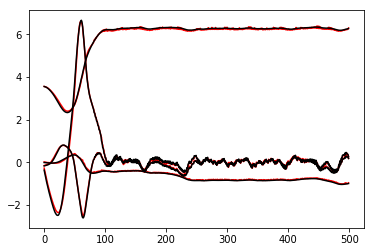

In [100]:

for i in range(200):
    
    pred_states = model(states, actions, get_jacobian=True)
    loss = 0.
    for param in model.parameters():
        loss = loss + torch.abs(param).max()
    loss = loss + torch.mean(torch.pow(next_states-pred_states,2))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    clear_output(wait=True)
    print('iter ', i)
    plt.plot(pred_states.data.numpy(),'r')
    plt.plot(next_states.data.numpy(),'k')
    plt.pause(0.1)

iter  199


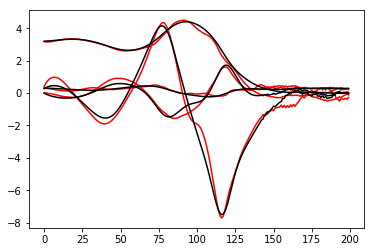

In [110]:
T = 200#states.shape[0]

for i in range(200):
    
    loss = 0.
    pred_states = []
    for t in range(T):
    
        if t == 0:
            state = states[0,:].unsqueeze(0)
    
        pred_state = model(state, actions[t,:].unsqueeze(0))
        pred_states.append(pred_state.data.squeeze().numpy())
        
        loss = loss + torch.sum(torch.pow(next_states[t,:].unsqueeze(0)-pred_state,2))#*(0.999**t)
        
        state = pred_state
        
    
#     loss = 0.
#     for param in model.parameters():
#         loss = loss + torch.abs(param).max()
#     loss = loss + torch.mean(torch.pow(next_states-pred_states,2))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    clear_output(wait=True)
    print('iter ', i)
    plt.plot(pred_states,'r')
    plt.plot(next_states.data.numpy()[:T],'k')
    plt.pause(0.1)

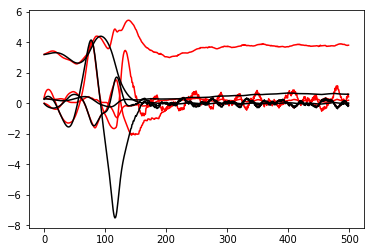

In [107]:
T = states.shape[0]

pred_states = []
for t in range(T):
    
    if t == 0:
        _x = states[0,:].unsqueeze(0)
    
    _x = model(_x, actions[t,:].unsqueeze(0))
    pred_states.append(_x.data.squeeze().numpy())

plt.plot(pred_states, 'r')
plt.plot(next_states.data.numpy(),'k')

    